TP, FP, FN, TN: 3613 156975 19661 3056215
Precision: 0.02249856776346911
Recall: 0.15523760419351398
F1 Score: 0.03930121482059456
IoU: 0.020044494005514484
Accuracy: 0.9454231531696318
Specificity: 0.9511466797792845
Dice: 0.03930121482059456
FPR: 0.04885332022071522
FNR: 0.844762395806443
Balanced Accuracy: 0.5531921419863992


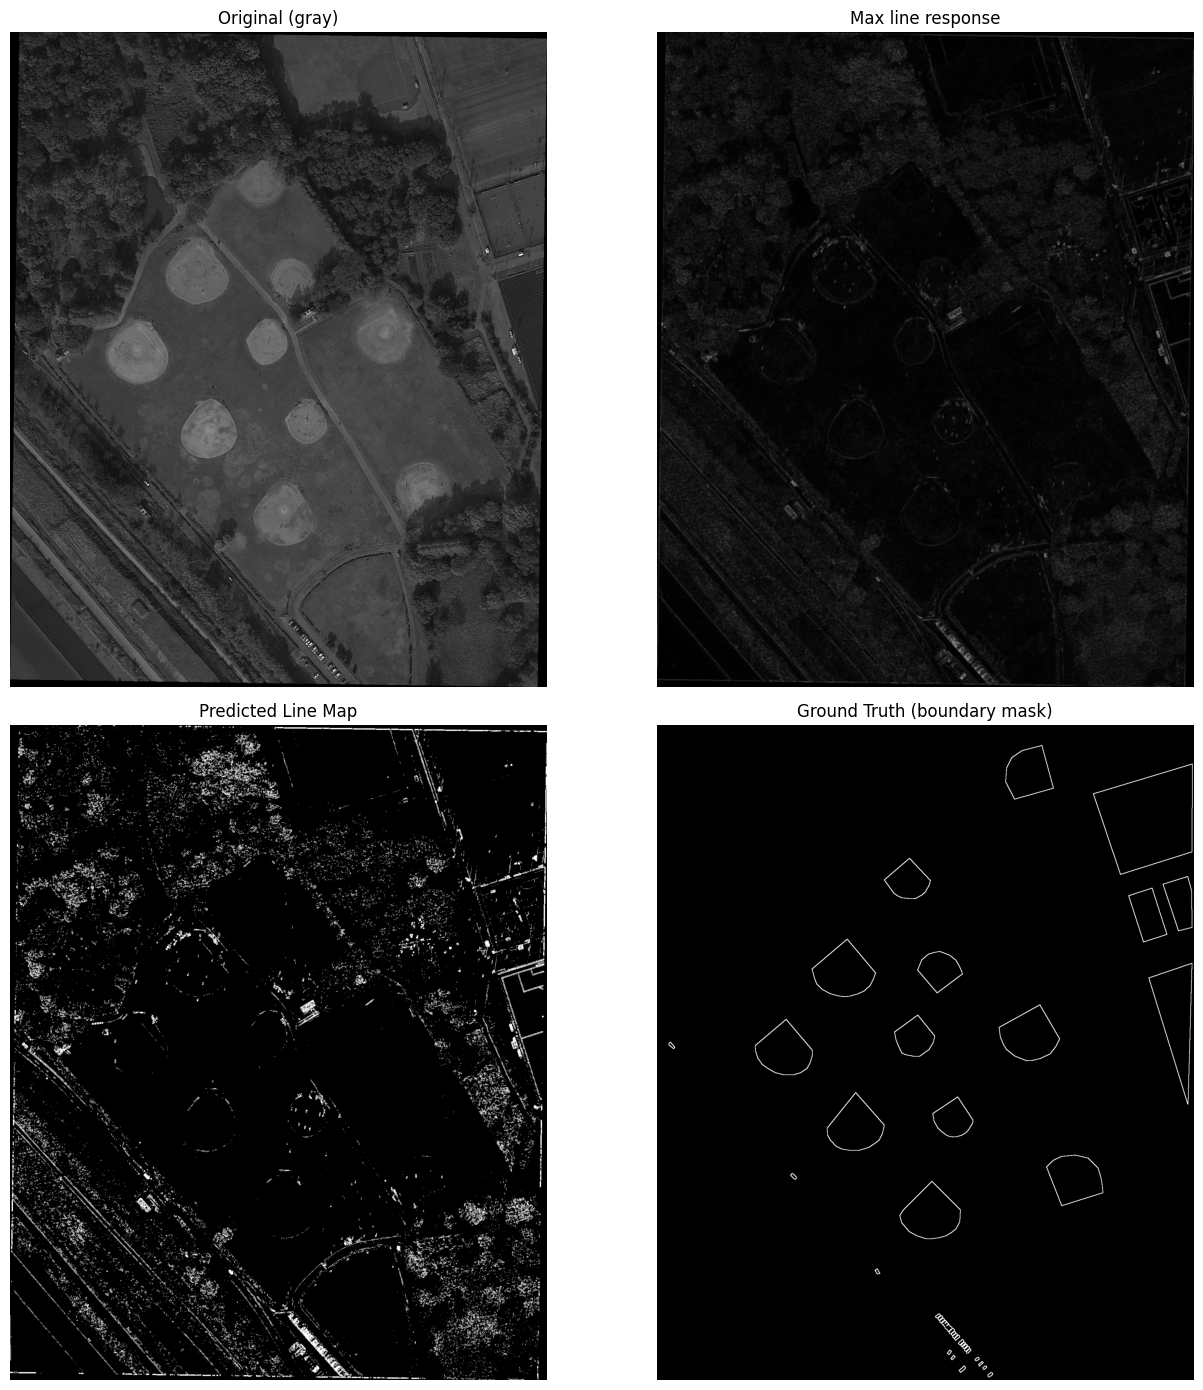

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =======================================================
# 1. Load image
# =======================================================
img_bgr = cv2.imread("P0049.png")
if img_bgr is None:
    raise FileNotFoundError("Could not load P0049.png")

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)

# =======================================================
# 2. Directional line kernels (unchanged)
# =======================================================
k0 = np.array([[-1,-1,-1],[ 2, 2, 2],[-1,-1,-1]], np.float32)
k90 = np.array([[-1,2,-1],[-1,2,-1],[-1,2,-1]], np.float32)
k45 = np.array([[-1,-1,2],[-1, 2,-1],[ 2,-1,-1]], np.float32)
k135 = np.array([[ 2,-1,-1],[-1, 2,-1],[-1,-1, 2]], np.float32)
kernels = [k0, k45, k90, k135]

# =======================================================
# 3. Apply kernels
# =======================================================
responses = [cv2.filter2D(img_blur, cv2.CV_32F, k) for k in kernels]
R0, R45, R90, R135 = responses

stacked = np.stack([np.abs(R0), np.abs(R45), np.abs(R90), np.abs(R135)], axis=-1)
R_max = np.max(stacked, axis=-1)

# =======================================================
# 4. Line map (unchanged)
# =======================================================
T = np.percentile(R_max, 95)
line_map = (R_max > T).astype(np.uint8)

# =======================================================
# 5. Load instance mask → convert to boundary GT
# =======================================================
gt_raw = cv2.imread("images/P0049_instance_color_RGB.png", cv2.IMREAD_GRAYSCALE)
if gt_raw is None:
    raise FileNotFoundError("Could not load GT mask")

# instance mask >0 = semantic mask (object regions)
semantic = (gt_raw > 0).astype(np.uint8) * 255

# extract edges: boundary = dilate - erode (correct GT)
kernel = np.ones((3,3), np.uint8)
dil = cv2.dilate(semantic, kernel, iterations=1)
ero = cv2.erode(semantic, kernel, iterations=1)
gt = ((dil - ero) > 0).astype(np.uint8)

# =======================================================
# 6. Scoring
# =======================================================
pred = line_map.astype(np.uint8)

TP = np.logical_and(pred == 1, gt == 1).sum()
FP = np.logical_and(pred == 1, gt == 0).sum()
FN = np.logical_and(pred == 0, gt == 1).sum()
TN = np.logical_and(pred == 0, gt == 0).sum()

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1_score  = 2 * precision * recall / (precision + recall + 1e-9)
iou       = TP / (TP + FP + FN + 1e-9)
accuracy  = (TP + TN) / (TP + FP + FN + TN + 1e-9)
specificity = TN / (TN + FP + 1e-9)
dice = f1_score
fpr = FP / (FP + TN + 1e-9)
fnr = FN / (TP + FN + 1e-9)
balanced_accuracy = (recall + specificity) / 2

print("TP, FP, FN, TN:", TP, FP, FN, TN)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("IoU:", iou)
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Dice:", dice)
print("FPR:", fpr)
print("FNR:", fnr)
print("Balanced Accuracy:", balanced_accuracy)

# =======================================================
# 7. Final visualization
# =======================================================
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title("Original (gray)")
plt.imshow(img_gray, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Max line response")
plt.imshow(R_max, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Predicted Line Map")
plt.imshow(pred, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Ground Truth (boundary mask)")
plt.imshow(gt, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


pred shape: (1988, 1628) gt shape: (1988, 1628)
pred foreground pixels: 291553 gt foreground pixels: 23274
TP, FP, FN, TN: 3301 288252 19973 2924938
Precision: 0.011322126680226198
Recall: 0.14183208730771926
F1 Score: 0.020970247014687686
IoU: 0.010596226318188497
Accuracy: 0.904764891560666
Specificity: 0.9102910192052133
Dice: 0.020970247014687686
FPR: 0.08970898079478647
FNR: 0.8581679126922378
Balanced Accuracy: 0.5260615532564663


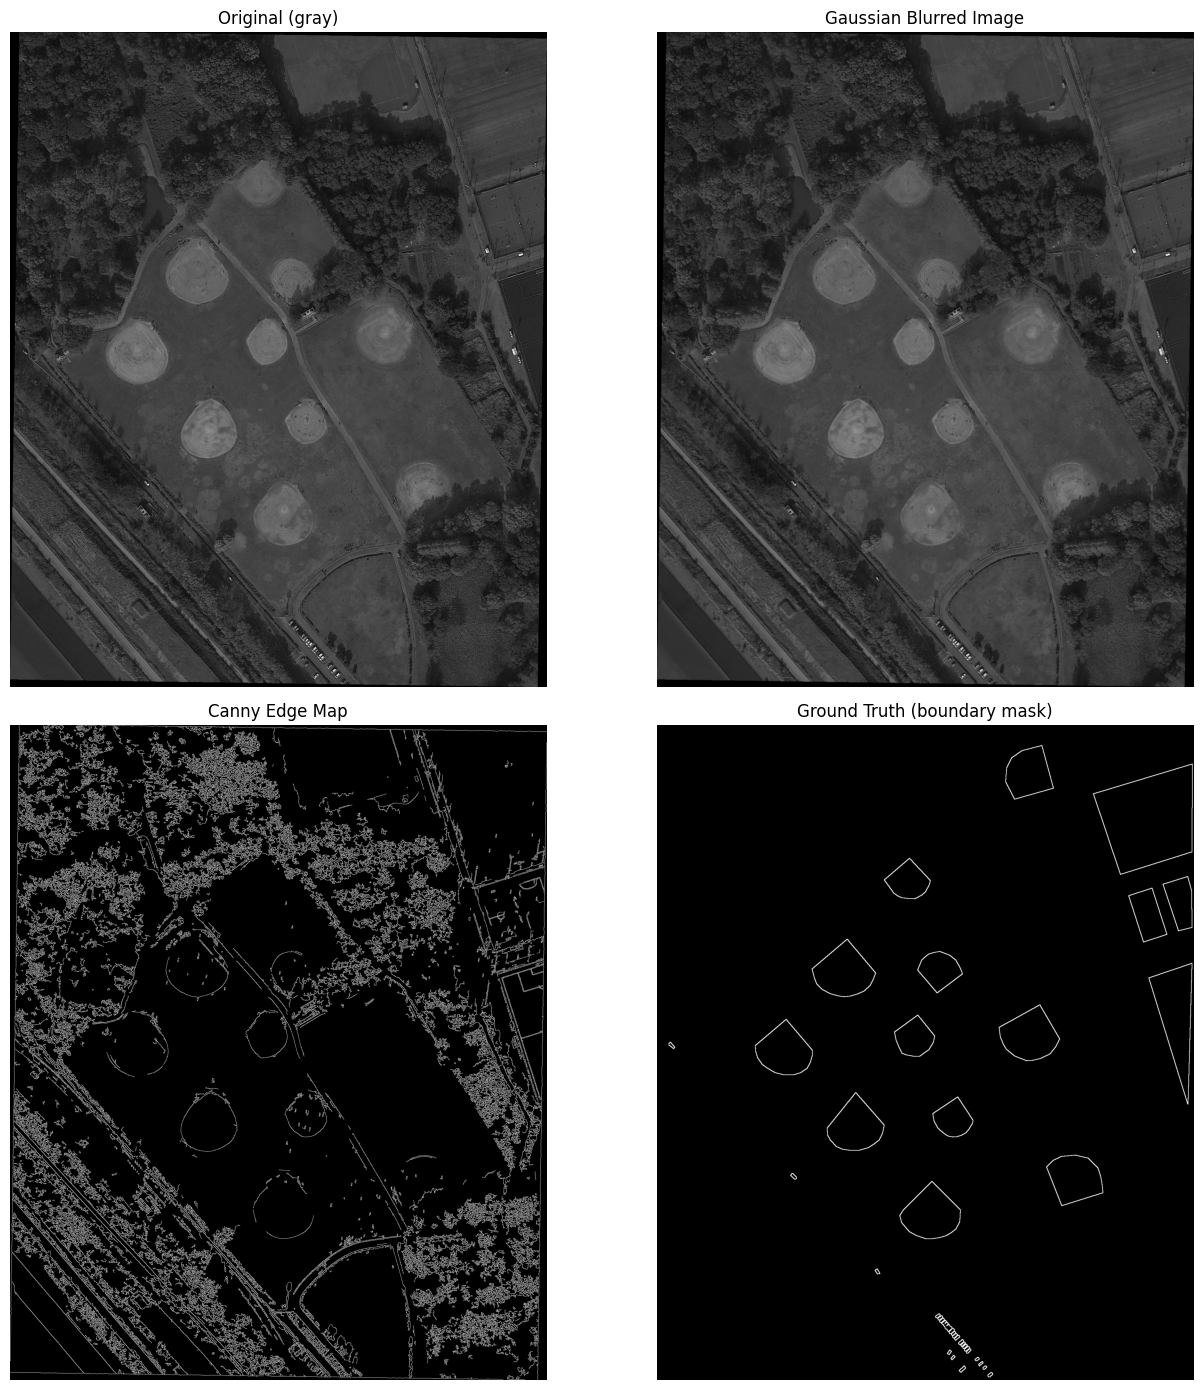

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =======================================================
# 1. Load image
# =======================================================
img_bgr = cv2.imread("P0049.png")
if img_bgr is None:
    raise FileNotFoundError("Could not load P0049.png")

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Gaussian blur helps Canny (less noise → fewer spurious edges)
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)


# =======================================================
# 2. Canny edge detection
# =======================================================
# You can tune these thresholds if needed
low_thresh = 50
high_thresh = 150

edges = cv2.Canny(img_blur, low_thresh, high_thresh)

# Canny output is 0 or 255 -> convert to 0/1 for metrics
pred = (edges > 0).astype(np.uint8)


# =======================================================
# 3. Load instance mask → convert to boundary GT
# =======================================================
gt_raw = cv2.imread("images/P0049_instance_color_RGB.png", cv2.IMREAD_GRAYSCALE)
if gt_raw is None:
    raise FileNotFoundError("Could not load images/P0049_instance_color_RGB.png")

# Instance mask: >0 means object region
semantic = (gt_raw > 0).astype(np.uint8) * 255

# Boundary extraction: dilate - erode
kernel = np.ones((3, 3), np.uint8)
dil = cv2.dilate(semantic, kernel, iterations=1)
ero = cv2.erode(semantic, kernel, iterations=1)

# Thin boundary mask (0/1)
gt = ((dil - ero) > 0).astype(np.uint8)

print("pred shape:", pred.shape, "gt shape:", gt.shape)
print("pred foreground pixels:", pred.sum(), "gt foreground pixels:", gt.sum())


# =======================================================
# 4. Metrics
# =======================================================
TP = np.logical_and(pred == 1, gt == 1).sum()
FP = np.logical_and(pred == 1, gt == 0).sum()
FN = np.logical_and(pred == 0, gt == 1).sum()
TN = np.logical_and(pred == 0, gt == 0).sum()

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1_score  = 2 * precision * recall / (precision + recall + 1e-9)
iou       = TP / (TP + FP + FN + 1e-9)

accuracy  = (TP + TN) / (TP + FP + FN + TN + 1e-9)
specificity = TN / (TN + FP + 1e-9)
dice = f1_score
fpr = FP / (FP + TN + 1e-9)
fnr = FN / (TP + FN + 1e-9)
balanced_accuracy = (recall + specificity) / 2

print("TP, FP, FN, TN:", TP, FP, FN, TN)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("IoU:", iou)
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Dice:", dice)
print("FPR:", fpr)
print("FNR:", fnr)
print("Balanced Accuracy:", balanced_accuracy)


# =======================================================
# 5. Visualization
# =======================================================
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title("Original (gray)")
plt.imshow(img_gray, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Gaussian Blurred Image")
plt.imshow(img_blur, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Canny Edge Map")
plt.imshow(pred, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Ground Truth (boundary mask)")
plt.imshow(gt, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
